In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from __future__ import division
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
houses = pd.read_csv('./data/train.csv')
test_houses = pd.read_csv('./data/test.csv')

In [3]:
houses.shape

(1460, 81)

#### Check for outliers

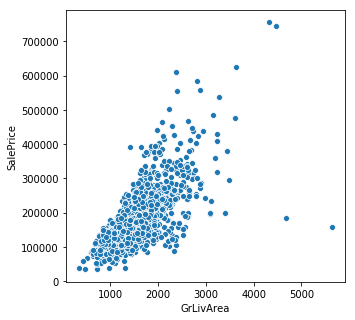

In [4]:
plt.figure(figsize=(5, 5))
sns.scatterplot(houses['GrLivArea'], houses['SalePrice'])
plt.show()

#### Remove houses which have GrLivArea > 4,000

In [5]:
houses = houses.loc[houses['GrLivArea'] < 4000, :]

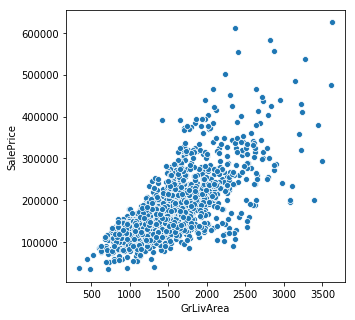

In [6]:
plt.figure(figsize=(5, 5))
sns.scatterplot(houses['GrLivArea'], houses['SalePrice'])
plt.show()

#### Check SalePrice distribution

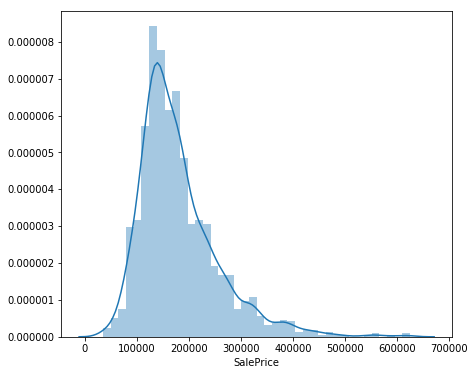

In [7]:
plt.figure(figsize=(7, 6))
sns.distplot(houses['SalePrice'])
plt.show()

### Rescale SalePrice

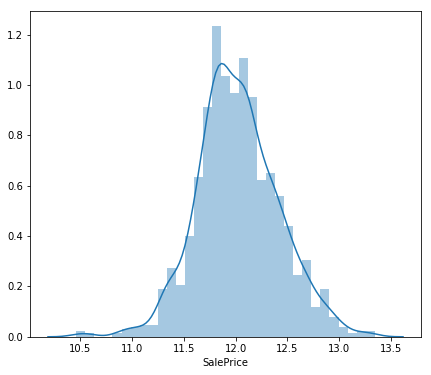

In [8]:
houses['SalePrice'] = np.log(houses['SalePrice'])

plt.figure(figsize=(7, 6))
sns.distplot(houses['SalePrice'])
plt.show()

In [9]:
houses.shape

(1456, 81)

drop Id, Utilities<br>
impute missing values<br>
convert MSSubClass to string<br>
convert ordinal category to number<br>
convert MoSold, YrSold to category<br>
add feature indicate how far the house from main/railRoad<br>
add feature indicate how big bedroom is<br>

num feature: log transform, rescale<br>
cate feature: one-hot

In [10]:
#save Id
train_Id = houses['Id']
test_Id = test_houses['Id']

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelBinarizer, LabelEncoder, OneHotEncoder
from scipy import stats

class AttributeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]
    
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

class NormalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
    
    def fit(self, X, y=None):
        if self.strategy == 'median':
            self.impute_values = X.median()
        elif self.strategy == 'mode':
            self.impute_values = X.mode().iloc[0]
        elif self.strategy == 'none':
            columns = X.columns.values
            self.impute_values = pd.Series(['None' for c in columns], index=columns)         
        elif self.strategy == 'zero':
            columns = X.columns.values
            self.impute_values = pd.Series([0 for c in columns], index=columns) 
        return self
    
    def transform(self, X, y=None):                
        for index, column in enumerate(X):  
            X[column] = X[[column]].fillna(self.impute_values[column])
        return X

class TakeLog(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        num_features = X.dtypes[X.dtypes != 'object'].index.values
        self.features_to_take_log = [feature for feature in num_features if X[feature].skew() > 0.5]
        return self
    
    def transform(self, X, y=None):
        for feature in self.features_to_take_log:
            X[feature] = np.log1p(X[feature])
            
        return X
    
class MainTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, take_log=False):  
        self.MedianImputer = NormalImputer('median')
        self.ModeImputer = NormalImputer('mode')
        self.ZeroImputer = NormalImputer('zero')
        self.NoneImputer = NormalImputer('none')
        
        self.none_impute = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual','Fence','FireplaceQu', 'MasVnrType', 'KitchenQual', 'PoolQC', 'MiscFeature', 'GarageQual', 'GarageFinish', 'GarageType']
        self.zero_impute = ['BsmtFinSF1', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath','BsmtUnfSF', 'GarageCars', 'BsmtFinSF2', 'GarageArea', 'GarageYrBlt']
        self.median_impute = ['LotFrontage', 'TotalBsmtSF']
        self.mode_impute = ['Exterior1st', 'Exterior2nd', 'GarageCond','MSZoning', 'Functional', 'Electrical', 'SaleType']
    
    def fit(self, X, y=None):  
        self.MedianImputer.fit(X[self.median_impute])
        self.ModeImputer.fit(X[self.mode_impute])
        self.ZeroImputer.fit(X[self.zero_impute])
        self.NoneImputer.fit(X[self.none_impute])
        
        return self
        
    def transform(self, X, y=None):
        #drop Id, Utilities
        X.drop(columns=['Id', 'Utilities'], inplace=True)
        
        #Impute missing values
        columns_with_na = self.median_impute + self.mode_impute + self.none_impute + self.zero_impute
        columns_without_na = [c for c in X.columns.values if c not in columns_with_na]
        
        median_imputed_df = self.MedianImputer.transform(X[self.median_impute])
        mode_imputed_df = self.ModeImputer.transform(X[self.mode_impute])
        none_imputed_df = self.NoneImputer.transform(X[self.none_impute])
        zero_imputed_df = self.ZeroImputer.transform(X[self.zero_impute])
        
        X = pd.concat([X[columns_without_na], median_imputed_df, mode_imputed_df, none_imputed_df, zero_imputed_df], axis=1)
        
        #transform MSSubClass
        X['MSSubClass'] = X['MSSubClass'].apply(lambda x: f"Type{x}")
        
        #transform ordinal features to numbers
        for column in X.columns.values:
            if ((column.endswith('Cond')) | (column.endswith('Qual')) | (column.endswith('QC')) | (column.endswith('Qu'))) & ((column != 'OverallQual') & (column != 'OverallCond') & ('Condition' not in column)):
                
                X[column] = X[column].replace({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
         
        X = X.replace({
            'Street' : {'Grvl' : 1, 'Pave' : 2},
            'Alley' : {'None':0, 'Grvl' : 1, 'Pave' : 2},
            'BsmtExposure' : {'None' : 0, 'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4},
            'BsmtFinType1' : {'None' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
            'BsmtFinType2' : {'None' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6},
            'GarageFinish' : {'None' : 0, 'Unf' : 1, 'RFn' : 2, 'Fin' : 3},
            'PavedDrive' : {'N' : 0, 'P' : 1, 'Y' : 2},
            'Fence' : {'None' : 0, 'MnWw' : 1, 'GdWo': 2, 'MnPrv' : 3, 'GdPrv' : 4}
        })
    
        #transform numerical to categorical
        X['MoSold'] = X['MoSold'].apply(lambda x: f"MoSold{x}")
        X['YrSold'] = X['YrSold'].apply(lambda x: f"YrSold{x}")
        
        return X
    

In [12]:
class FinalTransformer():

    def __init__(self):
        self.MainPipeline = Pipeline([
            ('main_transformer', MainTransformer()),
            ('take_log', TakeLog())
        ])
            
        self.OneHotEncoder = OneHotEncoder(sparse=False)
        
    
    def transform(self, data, is_train=True):
        if(is_train):    
            data_tr = self.MainPipeline.fit_transform(data)
            
            num_features = data_tr.dtypes[data_tr.dtypes != 'object'].index.values
            cate_features = data_tr.dtypes[data_tr.dtypes == 'object'].index.values
        
            num_pipeline = Pipeline([
                ('features_selector', AttributeSelector(num_features)),
                ('scaler', RobustScaler())
            ])
        
            cate_pipeline = Pipeline([
                ('features_selector', AttributeSelector(cate_features)),
                ('one_hot', self.OneHotEncoder)
            ])
        
            merge_pipeline = FeatureUnion([
                ('num_pipeline', num_pipeline),
                ('cate_pipeline', cate_pipeline)
            ])
            
            return merge_pipeline.fit_transform(data_tr)
            
        else:
            data_tr = self.MainPipeline.transform(data)
            
            num_features = data_tr.dtypes[data_tr.dtypes != 'object'].index.values
            cate_features = data_tr.dtypes[data_tr.dtypes == 'object'].index.values
        
            num_pipeline = Pipeline([
                ('features_selector', AttributeSelector(num_features)),
                ('scaler', RobustScaler())
            ])
        
            cate_pipeline = Pipeline([
                ('features_selector', AttributeSelector(cate_features)),
                ('one_hot', self.OneHotEncoder)
            ])
        
            merge_pipeline = FeatureUnion([
                ('num_pipeline', num_pipeline),
                ('cate_pipeline', cate_pipeline)
            ])
            
            return merge_pipeline.transform(data_tr)
            


In [13]:
train = houses.drop(columns=['SalePrice'])
test = test_houses.copy()


In [14]:
main_transformer = MainTransformer()

train_tr = main_transformer.fit_transform(train)

num_features = train_tr.dtypes[train_tr.dtypes != 'object'].index.values
cate_features = train_tr.dtypes[train_tr.dtypes == 'object'].index.values
        
num_pipeline = Pipeline([
    ('features_selector', AttributeSelector(num_features)),
    ('scaler', RobustScaler())
])

cate_pipeline = Pipeline([
    ('features_selector', AttributeSelector(cate_features)),
    ('one_hot', OneHotEncoder(sparse=False))
])

merge_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cate_pipeline', cate_pipeline)
])

merge_pipeline.fit_transform(train_tr)


array([[-0.25152806,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03247515,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43995802,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.10532815,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06136939,  0.        , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11570044,  0.        , -0.5       , ...,  0.        ,
         0.        ,  0.        ]])

In [15]:
test_tr = main_transformer.transform(test)

num_features = test_tr.dtypes[test_tr.dtypes != 'object'].index.values
cate_features = test_tr.dtypes[test_tr.dtypes == 'object'].index.values

merge_pipeline.transform(test_tr)

ValueError: Found unknown categories ['Type150'] in column 0 during transform

In [24]:
houses['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

In [26]:
test_houses['MSSubClass'][test_houses['MSSubClass'] == 150]

1358    150
Name: MSSubClass, dtype: int64